# DCA Ingest
Dieses Notebook dient dem Einlesen, analysieren und exportieren von Daten des Digitalen Konstruktionsarchivs
Im ersten Schritt werden die Daten eines Verzeichnisses mithilfe von DROID analysiert.
Anschliessend können die Daten individuell analysiert werden.
Im letzten Schritt wird diese Analyse in RDF form festgehalten und zusammen mit den Metadaten des digitalen Materials exportiert.

## Imports und Setup

In [1]:
%pip install pandas matplotlib pywaffle seaborn rdflib ipywidgets
import os
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Konfiguration

Hier werden alle Pfade und Parameter definiert.

In [2]:
# Pfad zum Datenset definieren
project_path = "Keller"
# Datenset (zu analysiernder Ordner) definieren
dataset_to_analyze = "07_Plaene_Visualisierungen"

# Dynamisches Home-Verzeichnis
home_dir = os.path.expanduser("~")
base_path = os.path.join(home_dir, "work")

# Pfade
droid_script_path = os.path.join(base_path, "27_DCA_Ingest/src/droid-binary-6.7.0-bin/droid.sh")
folder_to_analyze = os.path.join(base_path, f"dcaonnextcloud-500gb/DigitalMaterialCopies/{project_path}/{dataset_to_analyze}")
output_folder = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/{project_path}/{dataset_to_analyze}_results")
output_csv_path = os.path.join(output_folder, f"{dataset_to_analyze}_DROIDresults.csv")

# Pfad zu src/ hinzufügen, um lokale Module zu importieren
src_path = os.path.join(base_path, "27_DCA_Ingest/src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"Analyzing folder: {folder_to_analyze}")
print(f"Output will be saved to: {output_csv_path}")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/07_Plaene_Visualisierungen_DROIDresults.csv


## DROID-Analyse ausführen

Führt die DROID-Analyse auf dem konfigurierten Ordner aus.

In [4]:
# Dieser Abschnitt muss nach dem ersten Durchlauf nicht mehr ausgeführt werden
# try:
#     # Output-Ordner erstellen (falls nicht vorhanden)
#     os.makedirs(output_folder, exist_ok=True)

#     print(f"Analyzing folder: {folder_to_analyze}")
#     print(f"Output will be saved to: {output_csv_path}")

#     # DROID-Skript ausführen mit "best match only"
#     result = subprocess.run(
#         [
#             droid_script_path,
#             "-R", folder_to_analyze,
#             "-o", output_csv_path,
#             "-Pr", "profile.generateHash=true",
#             "-ff", "file_name not startswith ~$"
#         ],
#         check=True,
#         capture_output=True,
#         text=True
#     )

#     print("DROID output:", result.stdout)
#     print(f"Analysis complete. The result is saved in {output_csv_path}.")

# except subprocess.CalledProcessError as e:
#     print(f"An error occurred while running DROID: {e}")
#     print("DROID error output:", e.stderr)

# except PermissionError as e:
#     print(f"Permission error: {e}")
#     print("Bitte prüfe, ob du Schreibrechte für den Zielordner hast.")

# except FileNotFoundError as e:
#     print(f"Datei oder Verzeichnis nicht gefunden: {e}")
#     print("Bitte prüfe, ob alle Pfade korrekt sind und existieren.")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/07_Plaene_Visualisierungen_DROIDresults.csv
DROID output: 2025-11-17T08:56:10,166  INFO [main] DroidCommandLine:225 - Starting DROID.
2025-11-17T08:56:11,055  INFO [main] ProfileManagerImpl:129 - Creating profile: 1763369771055
2025-11-17T08:56:11,075  INFO [main] ProfileInstance:365 - Attempting state change [INITIALISING] to [VIRGIN]
2025-11-17T08:56:14,980  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1763369771055/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.template]
2025-11-17T08:56:20,066  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1763369771055/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.114.template]
2025-11-17T08:56:20,132  INFO [ma

## Erstellungsdatum hinzufügen

DROID liefert das letzte Änderungsdatum (LAST_MODIFIED), aber nicht das Erstellungsdatum.
Die folgende Zelle ergänzt die DROID-Ergebnisse mit dem Erstellungsdatum jeder Datei.

In [3]:
output_csv_path="/home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/07_Plaene_Visualisierungen_DROIDresults_with_norm_and_creation.csv"

## Analyse der DROID-Ergebnisse

Die folgenden Zellen führen verschiedene Analysen auf den DROID-Ergebnissen durch.

In [33]:
# Pfade für die Analyse konfigurieren
# CSV_PATH: Pfad zur DROID-Ausgabe-CSV
if "output_csv_path" in locals():
    CSV_PATH = output_csv_path
else:
    # Fallback, falls output_csv_path nicht definiert wurde
    CSV_PATH = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/Semiramis/{dataset_to_analyze}_results/analysis_result.csv")

# OUTPUT_DIR: Verzeichnis für Analyse-Ausgaben
OUTPUT_DIR = os.path.join(output_folder, "res")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"CSV-Datei für Analyse: {CSV_PATH}")
print(f"Ausgabeverzeichnis für Plots: {OUTPUT_DIR}")


df = pd.read_csv(CSV_PATH)

# Backup-Dateiname mit Zeitstempel
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_path = f"{CSV_PATH.replace('.csv', '')}_backup_{timestamp}.csv"

# Backup speichern
df.to_csv(backup_path, index=False)

# Danach Originaldatei überschreiben
df.to_csv(CSV_PATH, index=False)

print(f"Backup gespeichert unter: {backup_path}")


CSV-Datei für Analyse: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/07_Plaene_Visualisierungen_DROIDresults_with_norm_and_creation.csv
Ausgabeverzeichnis für Plots: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/res
Backup gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/07_Plaene_Visualisierungen_DROIDresults_with_norm_and_creation_backup_20251203_122001.csv


### Anzahl Dateien pro Format

Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen_results/res/format_counts.png


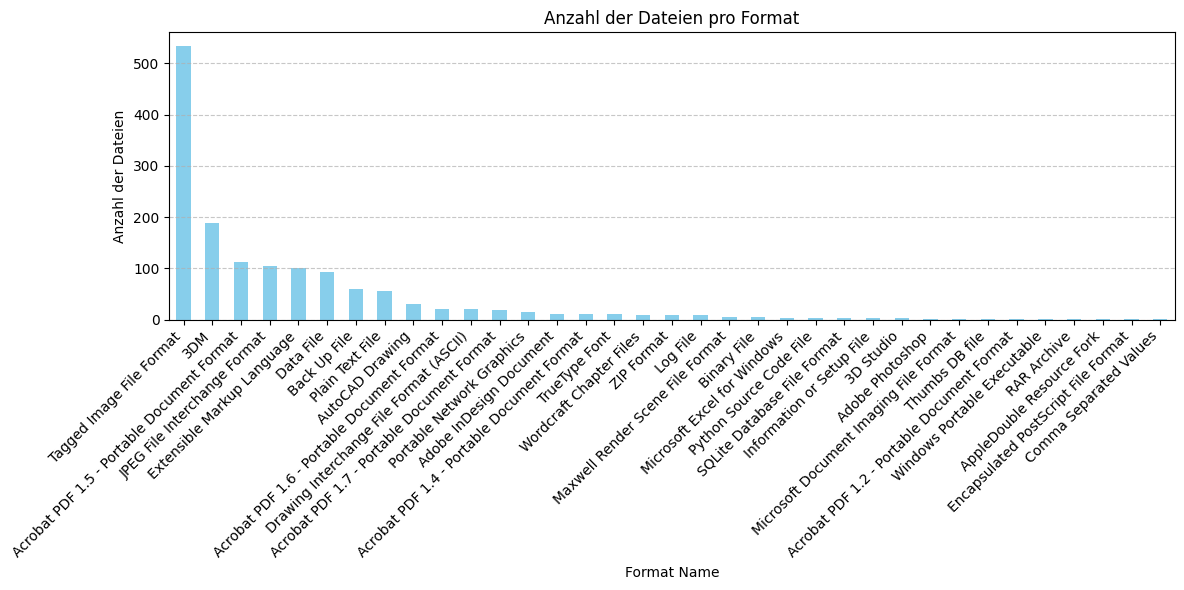

In [27]:
# Analyse: Anzahl der Dateien pro Format
try:
    from analyse_formats import analyse_formats
    analyse_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

### Häufigkeit Format X über Zeit

Gefilterte Zeilen für 'Tagged Image File Format': 534
Parsen abgeschlossen: 0 ungültige Datumswerte (von 534)
_parsed_dt
2009-05-12     3
2010-06-18    30
2010-08-27    19
2010-08-30     8
2010-08-31     5
2010-09-01     7
2010-09-02    23
2010-09-10     4
2010-09-30     9
2010-10-11    19
Name: count, dtype: int64
Plot gespeichert unter: plots/format_counts.png


/home/renku/work/27_DCA_Ingest/src/analyse_format_over_creation_time.py:31: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(s, errors='coerce', infer_datetime_format=True, utc=True)


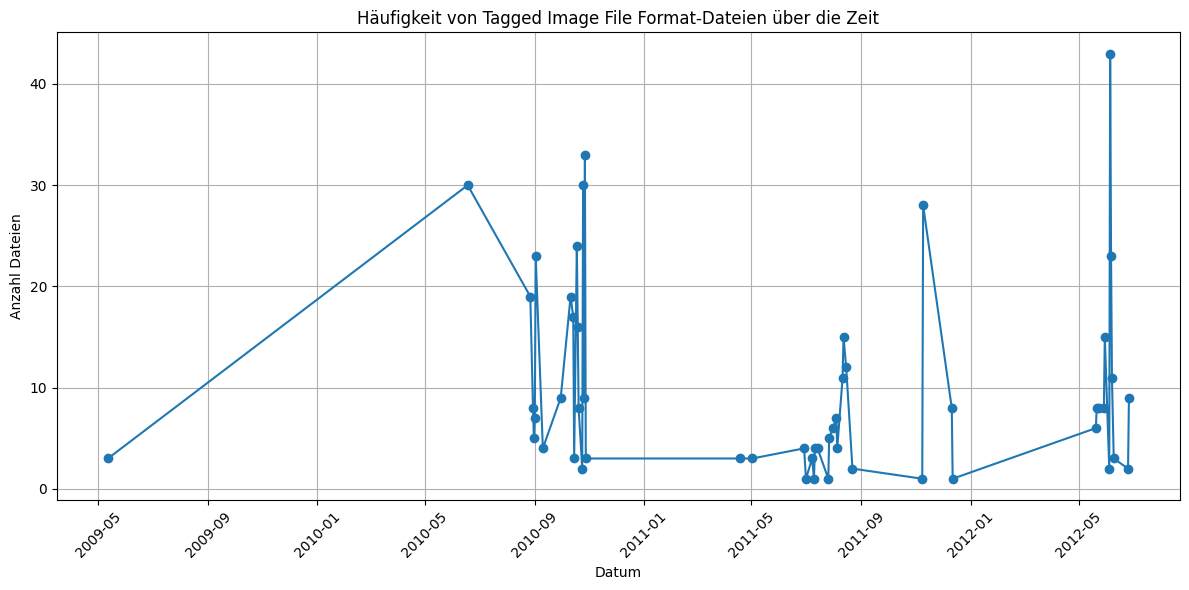

In [28]:
from analyse_format_over_creation_time import analyse_format_over_creation_time_df
df = pd.read_csv(CSV_PATH)  # ggf sep/encoding anpassen

most_common_format = df["FORMAT_NAME"].dropna().astype(str).str.strip().value_counts().idxmax()
ts = analyse_format_over_creation_time_df(df, most_common_format, date_column="creation_iso", output_dir="plots", show_plot=True, verbose=True)

Gefilterte Zeilen für '3dm': 188
Parsen abgeschlossen: 1 ungültige Datumswerte (von 188)
_parsed_dt
2010-08-27    2
2010-08-30    4
2010-08-31    3
2010-09-01    1
2010-09-08    2
2010-09-09    2
2010-09-23    4
2010-09-24    2
2010-09-27    9
2010-09-28    4
Name: count, dtype: int64
Plot gespeichert unter: plots/format_counts.png


/home/renku/work/27_DCA_Ingest/src/analyse_format_over_creation_time.py:31: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(s, errors='coerce', infer_datetime_format=True, utc=True)


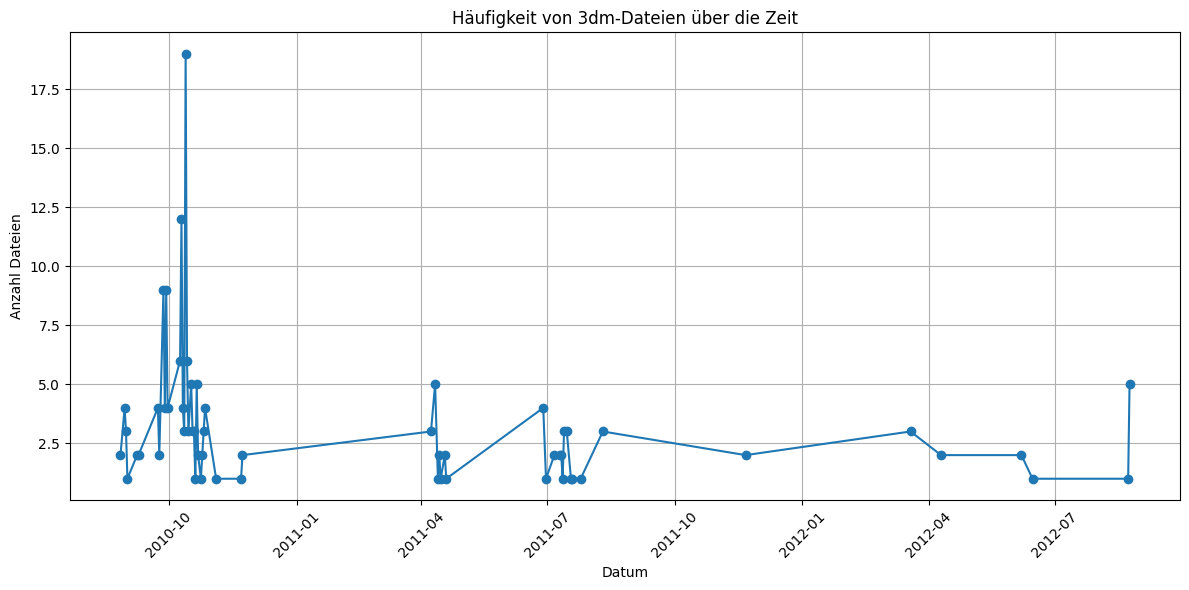

In [29]:
from analyse_format_over_creation_time import analyse_format_over_creation_time_df
df = pd.read_csv(CSV_PATH)  # ggf sep/encoding anpassen

format = "3dm"
ts = analyse_format_over_creation_time_df(df, format, date_column="creation_iso", output_dir="plots", show_plot=True, verbose=True)

In [36]:
# Identifizieren eines repräsentativen 3D Dokuments: Schritt 1 zeitliche Analyse

pd.set_option('display.max_rows', None)        # Alle Zeilen anzeigen
pd.set_option('display.max_columns', None)     # Alle Spalten anzeigen
pd.set_option('display.width', None)           # Keine feste Breite
pd.set_option('display.max_colwidth', None)    # Ganze Zellinhalte anzeigen


df['creation_iso'] = pd.to_datetime(df['creation_iso'], errors='coerce')

def filter_3dm_files_by_dates(df, start_date, end_date):
    # Konvertiere Eingaben in datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    filtered_df = df[(df['EXT'] == '3dm') & (df['creation_iso'].between(start_date, end_date))]
    return filtered_df

# Beispiel: Zeitraum vom 2025-01-01 bis 2025-12-01
result = filter_3dm_files_by_dates(df, '2012-01-01', '2012-12-01')
from IPython.display import display
display(result)  # Zeigt den kompletten DataFrame im Notebook


,ID,PARENT_ID,URI,FILE_PATH,NAME,METHOD,STATUS,SIZE,TYPE,EXT,LAST_MODIFIED,EXTENSION_MISMATCH,HASH,FORMAT_COUNT,PUID,MIME_TYPE,FORMAT_NAME,FORMAT_VERSION,norm_key,creation_iso,comment
823,824,819.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/120615_109_PLAENE_Template.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/120615_109_PLAENE_Template.3dm,120615_109_PLAENE_Template.3dm,Signature,Done,402479.0,File,3dm,2025-10-27T15:17:25,False,37246f4d84936146ceda02473749e3e7,1.0,fmt/864,NaN,3DM,5,07_plaene_visualisierungen/06_ausfuehrung/00_rhino-daten/120615_109_plaene_template.3dm,2012-06-15 16:53:14,NaN
838,839,819.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/120410_108_3D_Model_V17.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/120410_108_3D_Model_V17.3dm,120410_108_3D_Model_V17.3dm,Signature,Done,185913320.0,File,3dm,2025-10-27T15:17:25,False,3a5d5c414f36f8cfc989612f44384c5e,1.0,x-fmt/432,NaN,3DM,4,07_plaene_visualisierungen/06_ausfuehrung/00_rhino-daten/120410_108_3d_model_v17.3dm,2012-04-10 17:18:50,Potentialy final 3D representatino in Rhino
863,864,820.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/_Archiv/111121_108_3D_Model_v15.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/_Archiv/111121_108_3D_Model_v15.3dm,111121_108_3D_Model_v15.3dm,Signature,Done,189379342.0,File,3dm,2025-10-27T15:17:06,False,36635a1f17ed68a9cdc2498d08969908,1.0,x-fmt/432,NaN,3DM,4,07_plaene_visualisierungen/06_ausfuehrung/00_rhino-daten/_archiv/111121_108_3d_model_v15.3dm,2012-03-19 19:30:50,NaN
874,875,820.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/_Archiv/120319_108_3D_Model_V16.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/00_Rhino-Daten/_Archiv/120319_108_3D_Model_V16.3dm,120319_108_3D_Model_V16.3dm,Signature,Done,185914322.0,File,3dm,2025-10-27T15:17:14,False,3673ddc531baac1f17236fee6df8cede,1.0,x-fmt/432,NaN,3DM,4,07_plaene_visualisierungen/06_ausfuehrung/00_rhino-daten/_archiv/120319_108_3d_model_v16.3dm,2012-03-19 20:45:36,NaN
1187,1188,1182.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/08_Digitale_Fabrikation/10_Bauprozess/120824_Analyse_Verschiebung_Halterung_52.6mm/120824_108_3D_Model_Fassade_52.6mm.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/08_Digitale_Fabrikation/10_Bauprozess/120824_Analyse_Verschiebung_Halterung_52.6mm/120824_108_3D_Model_Fassade_52.6mm.3dm,120824_108_3D_Model_Fassade_52.6mm.3dm,Signature,Done,6398368.0,File,3dm,2025-10-27T15:26:50,False,38cc68844de96413f75b402797dfc075,1.0,fmt/864,NaN,3DM,5,07_plaene_visualisierungen/06_ausfuehrung/08_digitale_fabrikation/10_bauprozess/120824_analyse_verschiebung_halterung_52.6mm/120824_108_3d_model_fassade_52.6mm.3dm,2012-08-23 15:31:18,Only contains bricks surrounding mounting points
1224,1225,1197.0,file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/06_Ausfuehrung/08_Digitale_Fabrikation/10_Bauprozess/120824_ROB_Produktionsdaten_52.6mm_Steinhoehe/120824_108_3D_Modell_ROB_Produktionsdaten_52.6mm_Steinhoehe.3dm,07_Plaene_Visualisierungen/06_Ausfuehrung/08_Digitale_Fabrikation/10_Bauprozess/120824_ROB_Produktionsdaten_52.6mm_Steinhoehe/120824_108_3D_Modell_ROB_Produktionsdaten_52.6mm_Steinhoehe.3dm,120824_108_3D_Modell_ROB_Produktionsdaten_52.6mm_Steinhoehe.3dm,Signature,Done,6902446.0,File,3dm,2025-10-27T15:26:51,False,f409638d08634c3cdf9a0f536ae0518c,1.0,fmt/864,NaN,3DM,5,07_plaene_visualisierungen/06_ausfuehrung/08_digitale_fabrikation/10_bauprozess/120824_rob_produktionsdaten_52.6mm_steinhoehe/120824_108_3d_modell_rob_produktionsdaten_52.6mm_steinhoehe.3dm,2012-08-24 16:55:30,NaN
1439,14

In [35]:
# Identifizieren eines repräsentativen 3D Dokuments: Schritt 2 kommentieren

# Kommentarspalte hinzufügen
# df['comment'] = ''

# Kommentar in Zeile X hinzufügen
df.loc[838,'comment'] ='Potentialy final 3D representatino in Rhino'

# CSV überschreiben
df.to_csv(CSV_PATH, index=False)

### Monatliche Dateihäufigkeit

In [ ]:
# Analyse: Waffle-Chart für monatliche Dateihäufigkeit (verwende creation_iso)
from generate_waffle import generate_waffle_chart

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    df["creation_iso"] = pd.to_datetime(df["creation_iso"], errors="coerce")
    df_clean = df.dropna(subset=["creation_iso"])

    if len(df_clean) > 0:
        #start_year = int(df_clean["creation_iso"].dt.year.min())
        #end_year = int(df_clean["creation_iso"].dt.year.max())
        start_year = 2011
        end_year = 2012
        print(f"Waffle-Chart für Zeitraum: {start_year}-{end_year}")
        # Übergibt den bereits gelesenen DataFrame und verwendet die creation_iso Spalte
        generate_waffle_chart(df=df_clean, output_dir=OUTPUT_DIR, start_year=start_year, end_year=end_year, top_n=10, show_plot=False, date_col="creation_iso")
    else:
        print("Keine gültigen Datumsangaben in den Daten gefunden.")
else:
    print(f"CSV-Datei nicht gefunden: {CSV_PATH}")

Waffle-Chart für Zeitraum: 2011-2012


Heatmap für Zeitraum: 2021-2025
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/res/heatmap_top10_formats_by_month_2021_2025.png


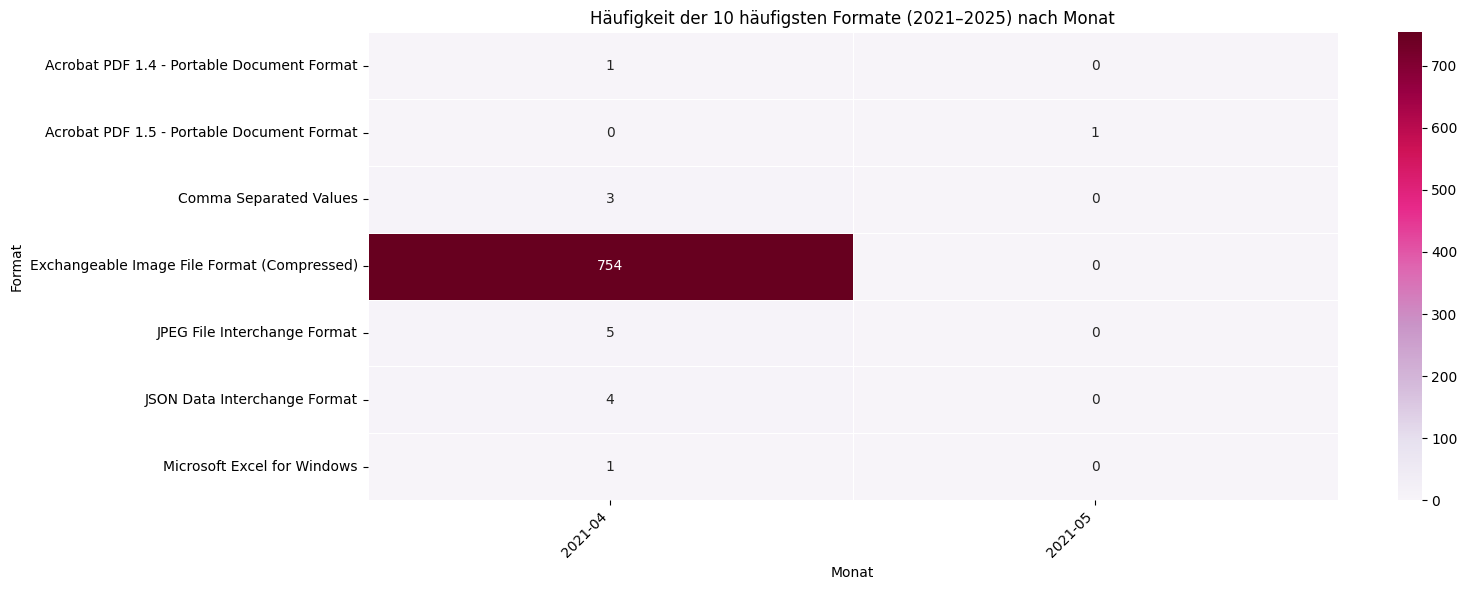

In [12]:
# Muss noch von LAST_MODIFIED auf creation_iso angepasst werden
# # Analyse: Heatmap der häufigsten Formate nach Monat
# try:
#     from analyse_format_heatmap import generate_format_heatmap
    
#     # Ermittle den Zeitraum aus den Daten
#     if os.path.exists(CSV_PATH):
#         df = pd.read_csv(CSV_PATH)
#         df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
#         df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
#         if len(df_clean) > 0:
#             start_year = df_clean["LAST_MODIFIED"].dt.year.min()
#             end_year = df_clean["LAST_MODIFIED"].dt.year.max()
#             print(f"Heatmap für Zeitraum: {start_year}-{end_year}")
#             generate_format_heatmap(CSV_PATH, OUTPUT_DIR, start_year, end_year, top_n=10, show_plot=False)
#         else:
#             print("Keine gültigen Datumsangaben in den Daten gefunden.")
#     else:
#         print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
# except ImportError as e:
#     print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Heatmap.")
#     print("Installieren Sie seaborn falls benötigt: pip install seaborn")
# except Exception as e:
#     print(f"Fehler bei generate_format_heatmap: {e}")